<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/time_perception_fintech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1048230413.py:30: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, interval=INTERVAL, period=PERIOD, progress=False)


BTCUSD: ⟨dτ/dt⟩ = 2.000


/tmp/ipython-input-1048230413.py:30: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, interval=INTERVAL, period=PERIOD, progress=False)


EURUSD: ⟨dτ/dt⟩ = 2.000


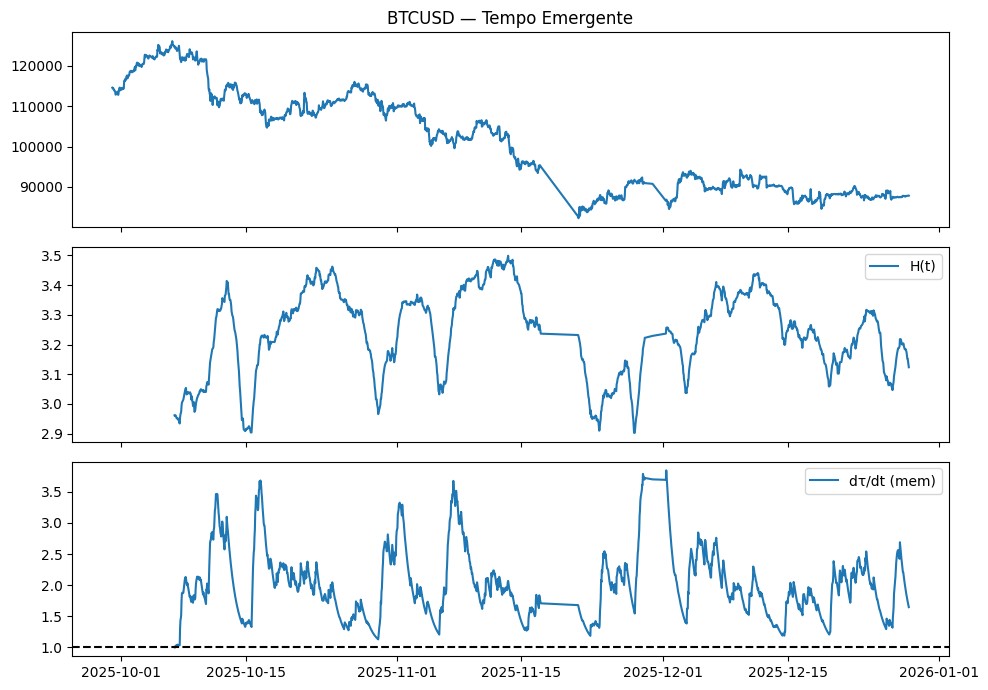

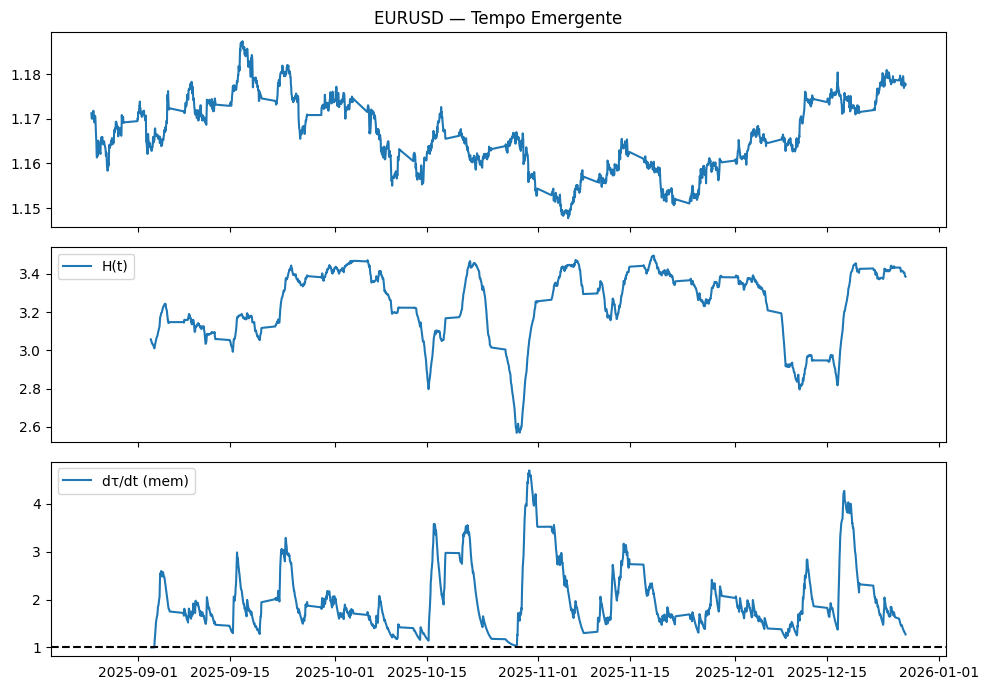

In [2]:
!pip install yfinance pandas numpy
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ==============================
# Configuração
# ==============================

SYMBOLS = {
    "BTCUSD": "BTC-USD",
    "EURUSD": "EURUSD=X"
}

INTERVAL = "1h"
PERIOD = "90d"

VOL_WIN = 24
TRANS_WIN = 168
MEM_SPAN = 48
ALPHA = 1.0
NSTATES = 9

# ==============================
# Funções
# ==============================

def download(symbol):
    df = yf.download(symbol, interval=INTERVAL, period=PERIOD, progress=False)
    df = df.rename(columns=str.lower)
    return df.dropna()

def returns(df):
    return np.log(df["close"]).diff()

def rolling_vol(ret, win=24):
    return ret.rolling(win).std()

def discretize_states(ret, vol):
    r1, r2 = ret.quantile([0.33, 0.66])
    v1, v2 = vol.quantile([0.33, 0.66])
    rb = pd.cut(ret, [-np.inf, r1, r2, np.inf], labels=[0,1,2])
    vb = pd.cut(vol, [-np.inf, v1, v2, np.inf], labels=[0,1,2])
    return (rb.astype(float)*3 + vb.astype(float)).astype("Int64")

def transition_entropy(states):
    valid = (~pd.isna(states[:-1])) & (~pd.isna(states[1:]))
    a = states[:-1][valid].astype(int)
    b = states[1:][valid].astype(int)
    if len(a) < 10:
        return np.nan
    M = np.zeros((NSTATES, NSTATES))
    np.add.at(M, (a,b), 1)
    P = M / M.sum()
    p = P[P>0]
    return -(p*np.log(p)).sum()

def compute_time_effective(df):
    df = df.copy()
    df["ret"] = returns(df)
    df["vol"] = rolling_vol(df["ret"], VOL_WIN)
    df["state"] = discretize_states(df["ret"], df["vol"])

    H = []
    st = df["state"].values
    for i in range(len(df)):
        if i < TRANS_WIN:
            H.append(np.nan)
        else:
            H.append(transition_entropy(st[i-TRANS_WIN:i]))
    df["H"] = H

    df["sigma"] = (df["H"] - df["H"].shift(1)).clip(lower=0)
    df["Sigma_mem"] = df["sigma"].ewm(span=MEM_SPAN, adjust=False).mean()

    sbar = df["Sigma_mem"].dropna().mean()
    sbar = sbar if sbar > 0 else 1e-12

    df["dtau_dt"] = 1 + ALPHA * df["Sigma_mem"] / sbar
    df["tau"] = df["dtau_dt"].fillna(1).cumsum()

    return df

def plot_core(df, title):
    fig, ax = plt.subplots(3,1,sharex=True, figsize=(10,7))
    ax[0].plot(df.index, df["close"])
    ax[0].set_title(title)
    ax[1].plot(df.index, df["H"], label="H(t)")
    ax[1].legend()
    ax[2].plot(df.index, df["dtau_dt"], label="dτ/dt (mem)")
    ax[2].axhline(1, ls="--", c="k")
    ax[2].legend()
    plt.tight_layout()
    plt.show()

# ==============================
# Execução
# ==============================

results = {}

for name, symbol in SYMBOLS.items():
    df = download(symbol)
    out = compute_time_effective(df)
    results[name] = out
    print(f"{name}: ⟨dτ/dt⟩ = {out['dtau_dt'].mean():.3f}")

plot_core(results["BTCUSD"], "BTCUSD — Tempo Emergente")
plot_core(results["EURUSD"], "EURUSD — Tempo Emergente")
